In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import ELU, PReLU, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

In [10]:
def supervised_generator(image_files, mask_files, batch_size=8, size=(512, 512)):
    flood_labels = [1, 3,5]  

    while True:
        idx = np.random.choice(len(image_files), batch_size)
        batch_x, batch_y = [], []

        for i in idx:
            img = Image.open(image_files[i]).resize(size)
            mask = Image.open(mask_files[i]).resize(size)

            img = np.array(img)
            mask = np.array(mask)

            # Convert multi-class mask to binary mask (1 = flood, 0 = not flood)
            binary_mask = np.isin(mask, flood_labels).astype(np.uint8)
            binary_mask = np.expand_dims(binary_mask, axis=-1)

            # Normalize image
            if img.ndim == 2:
                img = np.stack([img]*3, axis=-1)
            else:
                img = img[:, :, :3]
            img = img / 255.0

            batch_x.append(img)
            batch_y.append(binary_mask)

        yield np.array(batch_x), np.array(batch_y)

In [14]:
import os
from glob import glob
from PIL import Image
import numpy as np

# Base path of dataset
base_path = "FloodNet-Supervised_v1.0"

test_images = sorted(glob(os.path.join(base_path, "test", "test-org-img", "*.jpg")))
test_masks  = sorted(glob(os.path.join(base_path, "test", "test-label-img", "*.png")))

test_gen = supervised_generator(test_images, test_masks)

In [15]:
def mean_iou(y_true, y_pred):
    # Extract first channel and ensure both tensors are float32
    yt0 = tf.cast(y_true[:,:,:,0], tf.float32)
    yp0 = tf.cast(y_pred[:,:,:,0] > 0.5, tf.float32)
    
    # Calculate intersection and union using reduce_sum instead of count_nonzero
    # for better numerical stability and batch processing
    intersection = tf.reduce_sum(yt0 * yp0, axis=[1, 2])
    union = tf.reduce_sum(tf.clip_by_value(yt0 + yp0, 0, 1), axis=[1, 2])
    
    # Calculate IoU with proper handling of division by zero
    iou = tf.where(tf.equal(union, 0), 
                   tf.ones_like(union), 
                   intersection / union)
    
    # Return mean IoU across the batch
    return tf.reduce_mean(iou)


In [6]:
def unet(sz = (512, 512, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  # f=4
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [7]:
model = unet()

In [8]:
model.load_weights("unet.weights.h5")  # load trained weights

E:\7thsem\Artificial_intelligence\Disaster-Risk_management_repo\disaster-risk-env\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 134 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


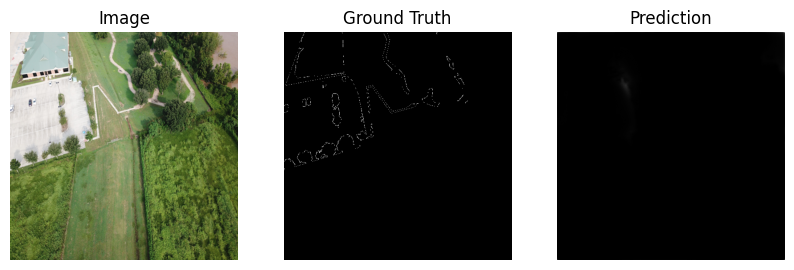

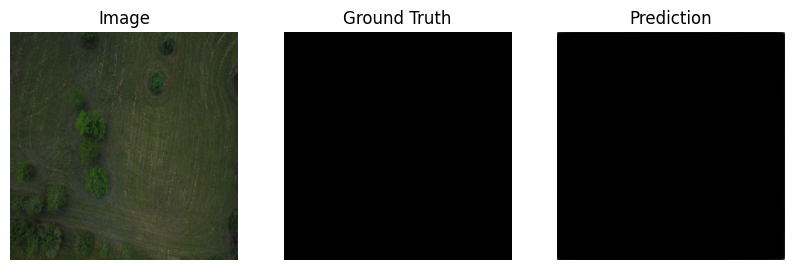

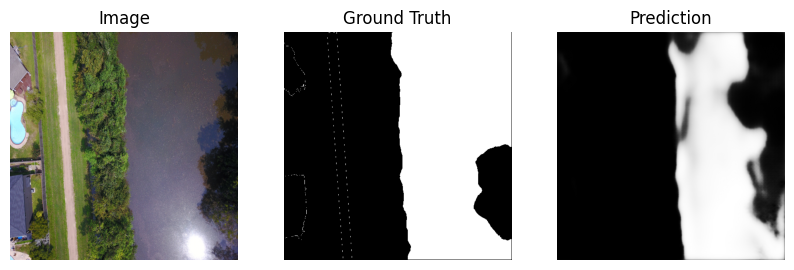

In [16]:
import matplotlib.pyplot as plt

x_sample, y_sample = next(test_gen)
pred = model.predict(x_sample)

for i in range(3):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(x_sample[i])
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(y_sample[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred[i].squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
    plt.show()
